## Imports

In [1]:
# offizielle libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lmfit.models import Model
%matplotlib inline

In [2]:
# selbstgeschrieben
import file_organizer as fo
from func import get_norm_cm
from func import ticks_handle

## FID

In [3]:
path = "data_day_two"
file_list = fo.load_file_list(path)
selection = fo.select_files(file_list, "meas", "J")
data = fo.load_files(selection)
data = fo.df_combine(data)
del data["iout"]
data["time"] = data["time"] * 1000
labels = list(data.columns)
labels.remove('time')

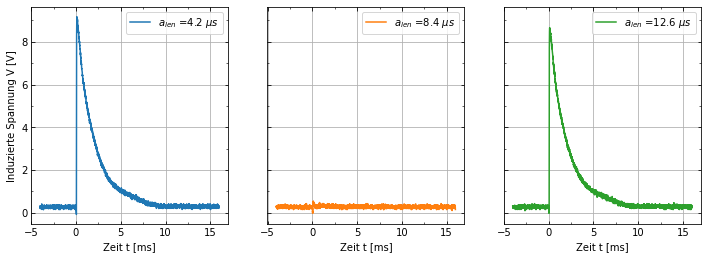

In [4]:
colors = ['tab:blue', 'tab:orange', 'tab:green']
fig, axs = plt.subplots(1,3,figsize=(12,4), sharey=True)

for i in range(3):
    data.plot(x='time',y=labels[i], ax=axs[i], color=colors[i], label=f'$a_{{len}}$ ={selection[i].A} $\\mu s$')
    axs[i].set_xlabel("Zeit t [ms]")
    axs[i].set_ylabel("Induzierte Spannung V [V]")
    axs[i].grid()
    ticks_handle(axs[i], which='both')
fig.savefig('IMAGES/lmo_fid.png')

## T1 aus Periode

Daten von Tag 1
> path = 'data_day_one'; 
> meas = E

zu kleine Zeiten P

Daten von Tag 2
> path = 'data_day_two', meas = K;

In [5]:
# Neuer Versuch
path = "data_day_two"
file_list = fo.load_file_list(path)
selection = fo.select_files(file_list, "meas", "K")
data = fo.load_files(selection)
data = fo.df_combine(data)
del data["iout"]
data["time"] = data["time"] * 1000
labels = list(data.columns)
labels.remove("time")
P1 = np.array([meas.P for meas in selection])
M1 = np.array([data[l].max() for l in labels])

In [6]:
selection[17]

Meas(filename='scope_116.csv', path='data_day_two', meas='K', comment='Variation Periodendauer', useful=True, F=21.162, A=4.2, B=nan, N=nan, tau=nan, P=80)

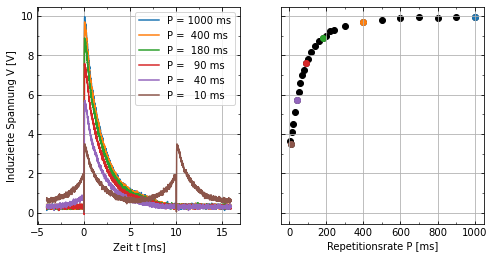

In [7]:
split=False
if not split:
    fig, (ax, bx) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
else:
    fig1, (ax) = plt.subplots(figsize=(4, 4))
    fig2, (bx) = plt.subplots(figsize=(4, 4))

inds = [0, 6, 11, 16, 21, 25]
data.plot(x="time",y=[labels[i] for i in inds], ax=ax,
          label=[f'P = {P1[i]:4.0f} ms' for i in inds])
ax.set_xlabel("Zeit t [ms]")
ax.set_ylabel("Induzierte Spannung V [V]")
ax.legend()

bx.scatter(P1, M1, color='black')
for idx in inds:
    bx.scatter(P1[idx], M1[idx])
bx.set_xlabel("Repetitionsrate P [ms]")
bx.set_ylabel("Induzierte Spannung V [V]")
bx.set_ylim(*ax.get_ylim())

#bx.plot(P, res.best_fit)
#bx.hlines(M0, xmin=0, xmax=1000, color='gray',ls='--')
#bx.vlines(T1, ymin=0, ymax=10, color='gray',ls='--')
#print(f'{T1=} ms')

ax.grid()
bx.grid()
ticks_handle(ax, which='both')
ticks_handle(bx, which='both')

if not split:
    fig.savefig('IMAGES/lmo_t1_periode.png')
else:
    fig1.savefig('IMAGES/lmo_t1_periode_a.png')
    fig2.savefig('IMAGES/lmo_t1_periode_b.png')
plt.show()

In [8]:
def t1func(t, M0, T1):
    return M0*(1-np.exp(-(t)/T1))
model = Model(t1func, nan_policy='omit')

## T1 aus Echo-Methode

Daten: Tag 1, meas == H, Tau ungeüngedner Bereich

Data day two: meas == L

In [9]:
path = 'data_day_two'
file_list = fo.load_file_list(path)
selection = (fo.select_files(file_list,'meas','L'))

data = fo.load_files(selection)
for d in data:
    d['time'] = d['time']*1000

    
idx = [d['signal'].idxmax() for d in data]
M2 = np.array([d.loc[i, 'signal'] for i,d in zip(idx, data)])
P2 = np.array([d.loc[i, 'time'] for i,d in zip(idx, data)])

#P2 = np.append(P2, [37])
#M2 = np.append(M2, [0.5])

In [10]:
M2[17] = 0.43
P2[17] = 36

ran = list(range(45))
ran.remove(34)
ran.remove(38)

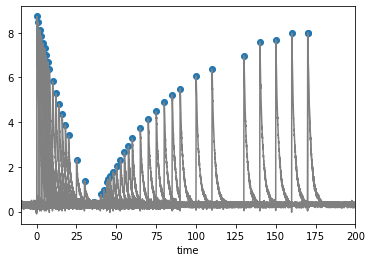

In [11]:
fig,ax = plt.subplots()
for i in ran:
    data[i].plot(x='time', y='signal', ax=ax,color='gray')
ax.set_xlim(-10, 200)

ax.scatter(P2[ran], M2[ran])
ax.legend().remove()

In [32]:
def t1func(t, M0, T1):
    return M0*(1-np.exp(-t/T1))
model = Model(t1func, nan_policy='omit')

In [91]:
def fit_t1(t, y, log=False):
    def fitfunc(t, M0, T1):
        return M0*(1-np.exp(-t/T1))

    model = Model(fitfunc, nan_policy='omit')
    res = model.fit(y, t=t, M0=10, T1=10)
    if log: print(res.fit_report())
    M0 = res.params['M0']
    T1 = res.params['T1']
    print(f'{M0=},\n {T1=}')
    return res

def fit_t1d(t, y,M0, log=False):
    def fitfunc(t, T1):
        return M0*(1-np.exp(-t/T1))

    model = Model(fitfunc, nan_policy='omit')
    res = model.fit(y, t=t, T1=10)
    if log: print(res.fit_report())
    #M0 = res.params['M0']
    T1 = res.params['T1']
    print(f'{M0=},\n {T1=}')
    return res

def fit_t1b(t, y, log=False):
    def fitfunc(t, M0, T1,c):
        return M0*(1-np.exp(-(t)/T1))+c

    model = Model(fitfunc, nan_policy='omit')
    res = model.fit(y, t=t, M0=10, T1=10,c=0)
    if log: print(res.fit_report())
        
    M0 = res.params['M0']
    T1 = res.params['T1']
    c = res.params['c']
    print(f'{M0=},\n {T1=},\n {c=}')
    return res

def fit_t1c(t, y, log=False):
    def fitfunc(t, M0, T1,c):
        return M0*(1-np.exp(-(t+c)/T1))

    model = Model(fitfunc, nan_policy='omit')
    res = model.fit(y, t=t, M0=10, T1=10,c=0)
    if log: print(res.fit_report())
        
    M0 = res.params['M0']
    T1 = res.params['T1']
    c = res.params['c']
    print(f'{M0=},\n {T1=},\n {c=}')
    return res

In [92]:
res1 = fit_t1(P1,M1)
res1b = fit_t1b(P1,M1)
res1c = fit_t1c(P1,M1)
res1d = fit_t1d(P1,M1, M0=9.8)

M0=<Parameter 'M0', value=9.361544800912846 +/- 0.226, bounds=[-inf:inf]>,
 T1=<Parameter 'T1', value=42.252219787963874 +/- 4.41, bounds=[-inf:inf]>
M0=<Parameter 'M0', value=6.745144625233928 +/- 0.0832, bounds=[-inf:inf]>,
 T1=<Parameter 'T1', value=85.19839295215836 +/- 2.4, bounds=[-inf:inf]>,
 c=<Parameter 'c', value=3.0795967900308994 +/- 0.0808, bounds=[-inf:inf]>
M0=<Parameter 'M0', value=9.824736479989104 +/- 0.0445, bounds=[-inf:inf]>,
 T1=<Parameter 'T1', value=85.19797097890586 +/- 2.4, bounds=[-inf:inf]>,
 c=<Parameter 'c', value=32.04122929979918 +/- 1.69, bounds=[-inf:inf]>
M0=9.8,
 T1=<Parameter 'T1', value=48.850478317784706 +/- 3.99, bounds=[-inf:inf]>


In [93]:
ran2 = [i for i in ran if i >= 17]
res2 = fit_t1(P2[ran2]-34,M2[ran2])
res2b = fit_t1b(P2[ran2],M2[ran2])
res2c = fit_t1c(P2[ran2],M2[ran2])



M0=<Parameter 'M0', value=8.965343537463905 +/- 0.0888, bounds=[-inf:inf]>,
 T1=<Parameter 'T1', value=59.58939154956516 +/- 1.2, bounds=[-inf:inf]>
M0=<Parameter 'M0', value=16.19085728186015 +/- 0.214, bounds=[-inf:inf]>,
 T1=<Parameter 'T1', value=57.468905733130846 +/- 1.62, bounds=[-inf:inf]>,
 c=<Parameter 'c', value=-7.3201909019904825 +/- 0.282, bounds=[-inf:inf]>
M0=<Parameter 'M0', value=8.870666356467416 +/- 0.0977, bounds=[-inf:inf]>,
 T1=<Parameter 'T1', value=57.468905273879635 +/- 1.62, bounds=[-inf:inf]>,
 c=<Parameter 'c', value=-34.57885664075125 +/- 0.333, bounds=[-inf:inf]>


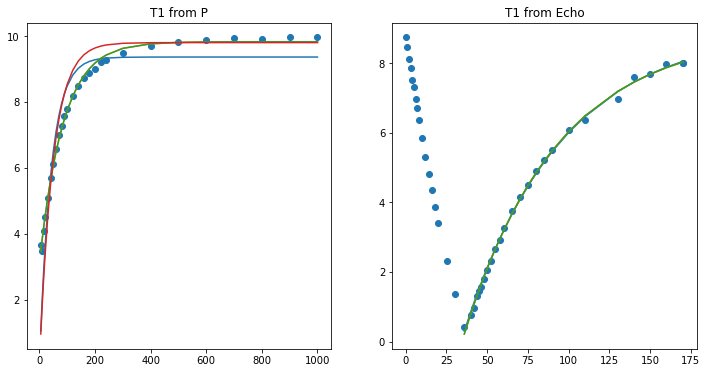

In [95]:
fig, (ax,bx) = plt.subplots(1,2, figsize=(12,6))
ax.scatter(P1,M1)
ax.plot(P1, res1.best_fit)
ax.plot(P1, res1b.best_fit)
ax.plot(P1, res1c.best_fit)
ax.plot(P1, res1d.best_fit)

ax.set_title('T1 from P')


bx.scatter(P2[ran], M2[ran])
bx.plot(P2[ran2], res2.best_fit)
bx.plot(P2[ran2], res2b.best_fit)
bx.plot(P2[ran2], res2c.best_fit)

bx.set_title('T1 from Echo')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c333ff75-d5d2-432c-b928-cf45631da0c3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>